L2-regularized logistic regression for binary or multiclass classification; trains a model (on `train.txt`), optimizes L2 regularization strength on `dev.txt`, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals and prints out the strongest coefficients for each class.

In [ ]:
from scipy import sparse
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm

In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[1].lstrip().rstrip()
            text = cols[2]

            X.append(text)
            Y.append(label)

    return X, Y


In [ ]:
class Classifier:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
            # tune the hyperparameter class_weight as 'balanced' to improve the imbalance distribution of data(majority class 0.77) -- test acc decreased
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

#             print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model
        

    def test(self):
        return self.log_reg.score(self.testX, self.testY)
        

    def printWeights(self, n=10):
        
        print(len(self.log_reg.coef_[0]))

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

    def printConfusionMatrix(self):
        self.y_pred = self.log_reg.predict(self.testX)
        print(precision_recall_fscore_support(self.testY, self.y_pred, pos_label='1', average='binary'))
        cm = confusion_matrix(self.testY, self.y_pred)
        print("\n\n")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=self.log_reg.classes_)
        disp.plot()
        plt.show()
        print("\n\n")

    def printMisclassifiedData(self):
        df = pd.DataFrame(columns=['Error Type', 'Category', 'Content'])
        misclassified = np.where(self.testY != self.y_pred)
        X,Y = load_data("test.txt")
        for i in misclassified[0]:
          category, content = X[i].split(';')
          t = "FP"
          if self.y_pred[i]=='0':
            t = "FN"
          df.loc[len(df.index)] = [t, category, content] 
        print(df)
        df.to_csv("LogRegMistakes.csv")

            

In [ ]:
def binary_bow_featurize(text):
    feats = {}
    #adding critical features according to the guideline
    #“Not clickbait” is a clickbait 
    text1 = text.lower()
    if 'not clickbait' in text1:
      feats['NOT_CLICKBAIT']=1
    else:
      feats['NOT_CLICKBAIT']=0
    #no change in test acc

    '''#Lots of Capitalized Letters -- clickbait
    cap_count = 0
    for c in text:
      if c.isupper():
        cap_count+=1
    cap_prop = cap_count/len(text)
    #feats['cap_count']=cap_count
    feats['cap_prop']=cap_prop
    # test acc decreased to 0.75'''

    words = nltk.word_tokenize(text)

    est_count = 0 

    for word in words:
      word=word.lower()
      if 'est' in word:
        est_count += 1
      feats['est_count'] = est_count  #Superlative adjectives and adverbs, increased test acc from 0.765 to 0.790

      feats[word] = 1
       # change 0/1 into word appear counts, decreased test acc from 0.790 to 0.785
           
    return feats



In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
def run(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)
    
    simple_classifier = Classifier(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()
    
    lower, upper=confidence_intervals(accuracy, len(devY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights(30)
    simple_classifier.printConfusionMatrix()
    simple_classifier.printMisclassifiedData()


In [ ]:
# Mount drive to save models and logs
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
root_folder = "/content/drive/My Drive/AP4 data/"
os.makedirs(root_folder, exist_ok=True)
os.chdir(root_folder)

Test accuracy for best dev model: 0.790, 95% CIs: [0.734 0.846]

660
1	2.283	most
1	1.727	world
1	1.673	debunk
1	1.648	10
1	1.450	est_count
1	1.343	top
1	1.243	best
1	1.198	$
1	1.161	this
1	1.071	moments
1	1.025	amd
1	1.010	last
1	1.008	out
1	1.007	universe
1	0.998	by
1	0.988	girl
1	0.976	million
1	0.960	fix
1	0.957	no
1	0.944	dramaalert
1	0.924	kitchen
1	0.916	worst
1	0.874	every
1	0.843	game
1	0.837	ever
1	0.807	hydroneer
1	0.802	cooked
1	0.797	deadly
1	0.795	#
1	0.791	car

0	-1.268	from
0	-0.917	|
0	-0.889	comedy
0	-0.859	building
0	-0.819	bbc
0	-0.818	review
0	-0.727	with
0	-0.701	my
0	-0.696	honest
0	-0.696	trailers
0	-0.695	fast
0	-0.687	probably
0	-0.674	vs
0	-0.662	chef
0	-0.651	test
0	-0.650	2017
0	-0.622	when
0	-0.609	your
0	-0.585	spent
0	-0.573	his
0	-0.570	code
0	-0.561	cs
0	-0.560	javascript
0	-0.551	show
0	-0.548	at
0	-0.543	joe
0	-0.540	live
0	-0.539	video
0	-0.503	guys
0	-0.491	fish

(0.5555555555555556, 0.43478260869565216, 0.4878048780487805, None)





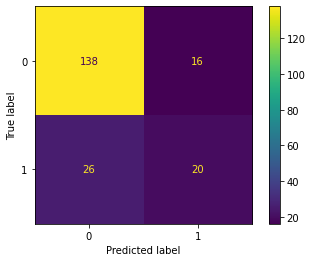




   Error Type              Category  \
0          FN                  Blog   
1          FN           Blog,Comedy   
2          FN    Blog,Entertainment   
3          FN            Automobile   
4          FP               Science   
5          FN           Tech,Comedy   
6          FP                  Blog   
7          FN               Science   
8          FP                  Blog   
9          FP                  Tech   
10         FP               Science   
11         FP                  Tech   
12         FN                  Food   
13         FN               Science   
14         FN            Automobile   
15         FN  Comedy,Entertainment   
16         FN                  Food   
17         FP                  Blog   
18         FN               Science   
19         FN                  Tech   
20         FP               Science   
21         FN          Blog,Science   
22         FN                  News   
23         FP           Informative   
24         FP         

In [ ]:
gid=0
trainingFile = "train.txt" 
devFile = "dev.txt" 
testFile = "test.txt" 
    
run(trainingFile, devFile, testFile)
